> __Purpose:__ Implement an initial privacy attack to quantify how much re-identiifcation and linkability risk exists from both filtered EMG data and for personalization parameters (the decoder). Thus, implement a basic ML model to link the EMG data back to the corresponding subject, and likewise to link the decoder matrices back to the corresponding subject.  

-- 7 Subjects, therefore pure guessing would be 14.28% correct on average

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# import seaborn
import time
import os
import pandas as pd
import pickle
import random

random.seed(a=1)

# Load In Data

In [2]:
keys = ['METACPHS_S106', 'METACPHS_S107','METACPHS_S108', 'METACPHS_S109', 'METACPHS_S110', 'METACPHS_S111', 'METACPHS_S112']

with open('Data\cphs_data_block1.pickle', 'rb') as handle:
    #refs_block1, poss_block1, dec_vels_block1, int_vel_block1, emgs_block1, Ws_block1, Hs_block1, alphas_block1, pDs_block1, times_block1, conditions_block1 = pickle.load(handle)
    _, _, _, _, emgs_block1, Ws_block1, _, _, _, times_block1, _ = pickle.load(handle)

with open('Data\cphs_data_block2.pickle', 'rb') as handle:
    #refs_block2, poss_block2, dec_vels_block2, int_vel_block2, emgs_block2, Ws_block2, Hs_block2, alphas_block2, pDs_block2, times_block2, conditions_block2 = pickle.load(handle)
    _, _, _, _, emgs_block2, Ws_block2, _, _, _, times_block2, _ = pickle.load(handle)

In [3]:
# Decoder updates
W = Ws_block1[keys[0]][0]
W[1:,:,:].shape # 7199 time points x (decoder dimensions is 2 x 6)
dold = W[0]
update_ix = []
for ix,d in enumerate(W[1:]):
  if (np.array_equal(dold,d)==False):
    update_ix.append(ix)
    dold = d

update_ix.append(len(W) - 1) 
update_ix = np.asarray(update_ix)
update_ix = np.hstack([[0],update_ix])

print(update_ix.shape)
print(update_ix)

(19,)
[    0  1200  2402  3604  4806  6008  7210  8412  9614 10816 12018 13220
 14422 15624 16826 18028 19230 20432 20769]


I'm just making the flatten array input DF here

In [4]:
dec_flattened_df1 = pd.DataFrame(columns=["Subject", "Condition", "Update Number", "Flattened Decoder"])
dec_flattened_df2 = pd.DataFrame(columns=["Subject", "Condition", "Update Number", "Flattened Decoder"])

dec_flattened_df1.head()

,Subject,Condition,Update Number,Flattened Decoder


In [5]:
num_conds = 8

t0 = time.time()

for key in keys:
    patient_dec1 = Ws_block1[key]
    patient_dec2 = Ws_block2[key]
    
    for my_cond in range(num_conds):
        for update_number, update_idx in enumerate(update_ix):
            dec_flattened_df1.loc[len(dec_flattened_df1)] = [key, my_cond, update_number, np.ravel(patient_dec1[my_cond, update_idx, :, :])]
            dec_flattened_df2.loc[len(dec_flattened_df2)] = [key, my_cond, update_number, np.ravel(patient_dec2[my_cond, update_idx, :, :])]
        
t1 = time.time()
total = t1-t0  
print(total)

4.131052732467651


Also make a DF of vector of norms (wrt ending point)

In [6]:
#dec_vec_norm_df1 = pd.DataFrame(columns=["Subject", "Condition", "Norm Vector"])
#dec_vec_norm_df2 = pd.DataFrame(columns=["Subject", "Condition", "Norm Vector"])

#dec_vec_norm_df1.head()

In [7]:
# Not working like it's supposed to 
'''
#
dec_per_cond_b1 = [0]*num_conds
dec_per_cond_b2 = [0]*num_conds
#
norm_per_cond_b1 = [0]*num_conds
norm_per_cond_b2 = [0]*num_conds
for cond in range(num_conds):  
    dec_per_cond_b1[cond] = [0]*len(update_ix)
    dec_per_cond_b2[cond] = [0]*len(update_ix)
    #
    norm_per_cond_b1[cond] = [0]*len(update_ix)
    norm_per_cond_b2[cond] = [0]*len(update_ix)

for key in keys:
    patient_dec1 = Ws_block1[key]
    patient_dec2 = Ws_block2[key]
    
    for my_cond in range(num_conds):
        for idx, my_update in enumerate(update_ix):
            dec_per_cond_b1[my_cond][idx] = patient_dec1[my_cond, my_update, :, :]
            dec_per_cond_b2[my_cond][idx] = patient_dec2[my_cond, my_update, :, :]
    
#################################
for my_cond in range(num_conds):
    for dec_num in range(len(update_ix)):
        norm_per_cond_b1[my_cond][dec_num] = np.linalg.norm(dec_per_cond_b1[my_cond][dec_num] - dec_per_cond_b1[my_cond][-1])
        norm_per_cond_b2[my_cond][dec_num] = np.linalg.norm(dec_per_cond_b2[my_cond][dec_num] - dec_per_cond_b2[my_cond][-1])
        
#################################
for key in keys:
    patient_dec1 = Ws_block1[key]
    patient_dec2 = Ws_block2[key]
    
    for my_cond in range(num_conds):
        for idx, my_update in enumerate(update_ix):
            dec_vec_norm_df1.loc[len(dec_vec_norm_df1)] = [key, my_cond, norm_per_cond_b1[my_cond]]
            dec_vec_norm_df2.loc[len(dec_vec_norm_df2)] = [key, my_cond, norm_per_cond_b2[my_cond]]
'''
0

0

Load in the other data
> This cell takes forever to run... not sure if it was actually any quicker to import vs just make it all over again

In [8]:
t0 = time.time()

emg_data_df1 = pd.read_csv("Data\emg_data1.csv")
emg_labels_df1 = pd.read_csv("Data\emg_labels1.csv")
dec_norms_df1 = pd.read_csv("Data\decoder_norms1.csv")

emg_data_df2 = pd.read_csv("Data\emg_data2.csv")
emg_labels_df2 = pd.read_csv("Data\emg_labels2.csv")
dec_norms_df2 = pd.read_csv("Data\decoder_norms2.csv")

t1 = time.time()
total = t1-t0  
print(total)

99.39638900756836


In [68]:
emg_data_df = pd.concat((emg_data_df1, emg_data_df2))
emg_labels_df = pd.concat((emg_labels_df1, emg_labels_df2))
dec_norms_df = pd.concat((dec_norms_df1, dec_norms_df2))

dec_flattened_df = pd.concat((dec_flattened_df1, dec_flattened_df2))
# This one isn't working yet
#dec_vec_norm_df = pd.concat((dec_vec_norm_df1, dec_vec_norm_df2))

In [10]:
print(emg_data_df.shape)
emg_data_df.drop('Unnamed: 0', axis=1, inplace=True)
emg_data_df.head()

(7232, 20771)


,0,1,2,3,4,5,6,7,8,9,...,20760,20761,20762,20763,20764,20765,20766,20767,20768,20769
0,0.0,0.0,0.0,10.778148,10.778148,10.778148,26.874088,43.189501,43.189501,38.594581,...,54.343173,54.343173,53.363208,53.363208,53.363208,53.363208,59.557374,59.557374,59.557374,55.634152
1,0.0,0.0,0.0,9.891218,9.891218,9.891218,23.589349,36.477933,36.477933,31.296507,...,79.894291,79.894291,86.860329,86.860329,86.860329,86.860329,71.319955,71.319955,71.319955,56.606641
2,0.0,0.0,0.0,1.606057,1.606057,1.606057,8.623857,15.845217,15.845217,17.957593,...,89.500295,89.500295,84.266738,84.266738,84.266738,84.266738,71.979639,71.979639,71.979639,65.918534
3,0.0,0.0,0.0,3.668527,3.668527,3.668527,7.165376,11.628290,11.628290,15.308951,...,68.943668,68.943668,66.983974,66.983974,66.983974,66.983974,64.104558,64.104558,64.104558,61.848159
4,0.0,0.0,0.0,1.411810,1.411810,1.411810,9.707134,15.677262,15.677262,18.922410,...,43.565918,43.565918,42.343590,42.343590,42.343590,42.343590,42.235306,42.235306,42.235306,41.818073


In [11]:
print(emg_labels_df.shape)
emg_labels_df.drop('Unnamed: 0', axis=1, inplace=True)
emg_labels_df.head()

(7232, 4)


,Subject,Condition,Channel
0,METACPHS_S106,0,0
1,METACPHS_S106,0,1
2,METACPHS_S106,0,2
3,METACPHS_S106,0,3
4,METACPHS_S106,0,4


In [12]:
print(dec_norms_df.shape)
dec_norms_df.drop('Unnamed: 0', axis=1, inplace=True)
dec_norms_df.head()

(2128, 5)


,Subject,Condition,Update Number,Frobenius Norm
0,METACPHS_S106,0,0,0.066360
1,METACPHS_S106,0,1,0.066360
2,METACPHS_S106,0,2,9.709390
3,METACPHS_S106,0,3,8.209080
4,METACPHS_S106,0,4,10.406943


In [13]:
print(dec_flattened_df.shape)
dec_flattened_df.head()

(2128, 4)


,Subject,Condition,Update Number,Flattened Decoder
0,METACPHS_S106,0,0,"[0.002722144351611262, 0.002605931562722017, 0..."
1,METACPHS_S106,0,1,"[0.002722144351611262, 0.002605931562722017, 0..."
2,METACPHS_S106,0,2,"[-0.34157085409453486, 0.08410593293763585, -0..."
3,METACPHS_S106,0,3,"[-0.1738624752800762, 0.003705171262358347, 0...."
4,METACPHS_S106,0,4,"[0.8321061501817386, -1.3261242289666402, 0.28..."


# ML Pipeline

In [14]:
# Machine learning
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [15]:
# Standard model fitting

def fit_ml_algo(algo, X_train, y_train, cv, verbose=False, num_decimals=3, testing=False):
    '''Runs given algorithm and returns the accuracy metrics'''
    
    model = algo.fit(X_train, y_train)
    
    # Notice that this is tested on the data it just trained on...
    acc = round(model.score(X_train, y_train) * 100, 3)
    
    # Cross Validation - this fixes that issue of validating on the data that the model was trained on
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs=-1)
    # Cross-validation metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, num_decimals)
    #pre_cv = round(metrics.precision_score(y_train, train_pred) * 100, num_decimals)
    #rec_cv = round(metrics.recall_score(y_train, train_pred) * 100, num_decimals)
    
    if verbose:
        print("Training predictions:")
        print(train_pred)
        print("Ground Truth:")
        print(y_train)
        print(f"One Off Accuracy: {acc}")
        print(f"CV Accuracy: {acc_cv}")
    
    if testing:
        return train_pred, acc, acc_cv, model
    
    return train_pred, acc, acc_cv

In [16]:
def train_test_val_split(input_df, label_df, rng_seed=2, validation=False, test_percent=0.3, val_percent=0.3):
    '''
    I don't think I need a validation set if I'm just doing cross_validation since that should take care of it for me
    '''
    
    x_train = input_df.copy(deep=True)
    y_train_reg = label_df

    ## TRAIN / TEST
    # Stratify might be good to ensure that all classes are represented, I'm not sure if it'll do that by default
    X_train, X_test, y_train, y_test = train_test_split(
        x_train, y_train_reg, test_size=test_percent, random_state=rng_seed)

    if validation:
        ## TRAIN / VAL
        # Might not use... easier to just use cross validation I think
        X_train_pv, X_val, y_train_pv, y_val = train_test_split(
            X_train, y_train, test_size=val_percent, random_state=rng_seed)

        return X_train_pv, y_train_pv, X_test, y_test, X_val, y_val
    else:
        return X_train, y_train, X_test, y_test

In [17]:
# Fully functionalized

def train_model(my_model, X_train, y_train, cv, res_df, verbose=False):
    #start_time = time.time()
    train_pred_log, acc, acc_cv = fit_ml_algo(my_model, X_train, y_train, cv)
    #log_time = (time.time() - start_time)
    if verbose:
        print(f"{str(my_model)}")
        print(f"Accuracy: {acc}")
        print(f"Accuracy CV 10-Fold: {acc_cv}")
        print()
        #print(f"Run Time: {log_time:.3f}")

    my_metrics_cols = ['Algorithm', 'One Off Acc', 'CV Acc', 'K Folds']
    temp_df = pd.DataFrame([[str(my_model), acc, acc_cv, cv]], columns=my_metrics_cols)
    res_df = pd.concat((res_df, temp_df))
    
    return res_df

In [18]:
def test_model(model, X_train, y_train, X_test, y_test, test_df, cv, num_decimals=3, verbose=False, my_cols=['Algorithm', 'CV Acc', 'Test Acc', 'K Folds']):
    _, _, acc_cv, trained_model = fit_ml_algo(model, X_train, y_train, cv, testing=True)
    y_pred = trained_model.predict(X_test)
    test_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, num_decimals)
    
    if verbose:
        print(str(model))
        print(f"CV Accuracy: {acc_cv}")
        print(f"Test Accuracy: {test_acc}")
        print()
        
    temp_df = pd.DataFrame([str(model), acc_cv, test_acc, cv], index=my_cols).T
    test_df = pd.concat((test_df, temp_df))
    return test_df

## Classification
1. Logistic Regression
2. K-Nearest Neighbor
3. Gaussian Naive Bayes
4. Linear SVC
5. Stochastic Gradient Descent
6. Decision Tree Classifier
7. Gradient Boosting Trees

In [19]:
# Set the number of k-folds
cv = 10

## 1) Linking Matrix Norms to Patients

In [20]:
norm_label_df = dec_norms_df.drop(["Condition", "Update Number", "Frobenius Norm"], axis=1)

In [21]:
key_to_num = dict()
num_to_key = dict()
for idx, key in enumerate(keys):
    key_to_num[key] = idx
    num_to_key[idx] = key

In [22]:
norm_label_df["Subject"] = norm_label_df["Subject"].map(key_to_num)
norm_label_df.head()

,Subject
0,0
1,0
2,0
3,0
4,0


In [23]:
# Result logs
my_metrics_cols = ['Algorithm', 'One Off Acc', 'CV Acc', 'K Folds']
res_df = pd.DataFrame(columns=my_metrics_cols)

norm1d_res_df = pd.DataFrame(columns=my_metrics_cols)
SSnorm1d_res_df = pd.DataFrame(columns=my_metrics_cols)
flatten_dec_res_df = pd.DataFrame(columns=my_metrics_cols)
SSflatten_dec_res_df = pd.DataFrame(columns=my_metrics_cols)
norm_vec_res_df = pd.DataFrame(columns=my_metrics_cols)
SSnorm_vec_res_df = pd.DataFrame(columns=my_metrics_cols)

In [24]:
my_models = [LogisticRegression(), KNeighborsClassifier(), GaussianNB(), LinearSVC(), SGDClassifier(), DecisionTreeClassifier(), GradientBoostingClassifier()]

## Case 1: 1D Norm

In [25]:
norm_input_df = dec_norms_df.drop(["Subject",  "Condition", "Update Number"], axis=1)
norm_input_df.head()

,Frobenius Norm
0,0.066360
1,0.066360
2,9.709390
3,8.209080
4,10.406943


In [26]:
try:
    X_train, y_train, X_test, y_test, X_val, y_val = train_test_val_split(norm_input_df, norm_label_df)
except ValueError:
    # You probably turned off validation so just remove the val sets
    print("Excepted value error")
    X_train, y_train, X_test, y_test = train_test_val_split(norm_input_df, norm_label_df)
y_train = np.ravel(y_train)

print(X_train.shape)
X_train.head()

(1489, 1)


,Frobenius Norm
420,3.567582
146,5.589772
266,0.069974
695,5.796815
372,17.938752


In [27]:
for model_num, model in enumerate(my_models):
    norm1d_res_df = train_model(model, X_train, y_train, cv, norm1d_res_df)

C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [28]:
norm1d_res_df.head(100)

,Algorithm,One Off Acc,CV Acc,K Folds
0,LogisticRegression(),17.931,16.857,10
0,KNeighborsClassifier(),52.048,30.356,10
0,GaussianNB(),19.073,17.260,10
0,LinearSVC(),19.610,17.931,10
0,SGDClassifier(),18.603,13.969,10
0,DecisionTreeClassifier(),100.000,28.946,10
0,GradientBoostingClassifier(),65.682,32.304,10


Now Test

In [29]:
test_df = pd.DataFrame(columns=['Algorithm', 'CV Acc', 'Test Acc', 'K Folds'])

for model_num, model in enumerate(my_models):
    test_df = test_model(model, X_train, y_train, X_test, y_test, test_df, cv)

C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepd

In [30]:
test_df.head()

,Algorithm,CV Acc,Test Acc,K Folds
0,LogisticRegression(),16.857,16.901,10
0,KNeighborsClassifier(),30.356,28.795,10
0,GaussianNB(),17.26,19.718,10
0,LinearSVC(),18.334,18.936,10
0,SGDClassifier(),14.238,13.928,10


## Case 2: Flatten Decoder Matrices as Input

In [31]:
flattened_input_df = dec_flattened_df.drop(["Subject",  "Condition", "Update Number"], axis=1)
flattened_input_df.head()

,Flattened Decoder
0,"[0.002722144351611262, 0.002605931562722017, 0..."
1,"[0.002722144351611262, 0.002605931562722017, 0..."
2,"[-0.34157085409453486, 0.08410593293763585, -0..."
3,"[-0.1738624752800762, 0.003705171262358347, 0...."
4,"[0.8321061501817386, -1.3261242289666402, 0.28..."


In [32]:
try:
    X_train, y_train, X_test, y_test, X_val, y_val = train_test_val_split(flattened_input_df, norm_label_df)
except ValueError:
    # You probably turned off validation so just remove the val sets
    print("Excepted value error")
    X_train, y_train, X_test, y_test = train_test_val_split(flattened_input_df, norm_label_df)
y_train = np.ravel(y_train)

print(X_train.shape)
X_train.head()

(1489, 1)


,Flattened Decoder
420,"[0.5594479988320739, 0.4812012592595234, -0.31..."
146,"[-0.05469055551972085, 0.08547177500493985, -0..."
266,"[-0.008973604228856694, -0.008313810900701315,..."
695,"[-0.05559843195043232, -1.0993648180373194, 0...."
372,"[2.0976718157092886, -1.4354093970974517, -0.0..."


Convert single element of a vector into a vector of single elements!

In [33]:
X_train2 = pd.DataFrame()
X_test2 = pd.DataFrame()
for my_row in range(X_train.shape[0]):
    test=pd.DataFrame(X_train.iloc[my_row,0]).T
    X_train2 = pd.concat((X_train2, test))
    
for my_row in range(X_test.shape[0]):
    test=pd.DataFrame(X_test.iloc[my_row,0]).T
    X_test2 = pd.concat((X_test2, test))
X_train2.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.559448,0.481201,-0.311722,-0.309007,0.106709,0.161785,-0.301699,-0.321967,-0.083060,0.570488,...,0.039315,0.361549,0.411409,0.181654,0.168465,0.048938,0.070892,-0.032129,0.055582,0.466536
0,-0.054691,0.085472,-0.139612,0.109828,-0.132205,-0.125863,0.872657,0.057642,1.215535,-0.042984,...,0.295885,-0.664531,-0.831946,1.214455,0.905204,-1.332841,-0.037715,0.540905,0.181231,-0.617622
0,-0.008974,-0.008314,-0.006412,-0.001125,-0.003369,-0.001689,-0.008623,-0.004556,-0.009388,-0.002210,...,-0.008424,-0.002359,-0.001530,-0.002416,-0.001757,-0.007078,-0.007921,-0.006530,-0.003725,-0.005481
0,-0.055598,-1.099365,0.040769,-0.288075,0.016066,-0.113498,0.082550,0.019032,-0.090005,-1.670067,...,0.003365,0.346554,-0.189199,0.189891,0.210803,0.022203,-0.021496,0.434912,-0.832817,0.034530
0,2.097672,-1.435409,-0.056953,1.670270,-1.501497,-0.962351,0.083523,2.733040,-1.270545,0.097296,...,-2.028840,-0.354640,2.231020,2.792864,-1.524705,2.493864,-0.648781,-1.369147,1.047059,-0.720754


In [34]:
for model_num, model in enumerate(my_models):
    print(f"{model_num} of {len(my_models)}")
    flatten_dec_res_df = train_model(model, X_train2, y_train, cv, flatten_dec_res_df)

0 of 7
1 of 7


C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


2 of 7
3 of 7


C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


4 of 7
5 of 7
6 of 7


In [35]:
flatten_dec_res_df.head(100)

,Algorithm,One Off Acc,CV Acc,K Folds
0,LogisticRegression(),87.911,70.853,10
0,KNeighborsClassifier(),83.815,76.494,10
0,GaussianNB(),71.592,69.778,10
0,LinearSVC(),83.277,70.987,10
0,SGDClassifier(),78.643,69.241,10
0,DecisionTreeClassifier(),100.000,66.085,10
0,GradientBoostingClassifier(),100.000,88.113,10


Test the models on the testing data

In [36]:
test_df = pd.DataFrame(columns=['Algorithm', 'CV Acc', 'Test Acc', 'K Folds'])
for model in my_models:
    test_df = test_model(model, X_train2, y_train, X_test2, y_test, test_df, cv, verbose=True)

LogisticRegression()
CV Accuracy: 70.853
Test Accuracy: 71.987



C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepd

KNeighborsClassifier()
CV Accuracy: 76.494
Test Accuracy: 76.526

GaussianNB()
CV Accuracy: 69.778
Test Accuracy: 72.926



C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()
CV Accuracy: 71.39
Test Accuracy: 73.396

SGDClassifier()
CV Accuracy: 69.107
Test Accuracy: 69.171

DecisionTreeClassifier()
CV Accuracy: 65.816
Test Accuracy: 67.293

GradientBoostingClassifier()
CV Accuracy: 88.046
Test Accuracy: 90.141



In [37]:
test_df.head(100)

,Algorithm,CV Acc,Test Acc,K Folds
0,LogisticRegression(),70.853,71.987,10
0,KNeighborsClassifier(),76.494,76.526,10
0,GaussianNB(),69.778,72.926,10
0,LinearSVC(),71.39,73.396,10
0,SGDClassifier(),69.107,69.171,10
0,DecisionTreeClassifier(),65.816,67.293,10
0,GradientBoostingClassifier(),88.046,90.141,10


Redo but try using Standard Scaler this time

In [38]:
from sklearn.preprocessing import StandardScaler

scaler_Xtrain2 = StandardScaler().fit(X_train2)
Xtrain2SS = scaler_Xtrain2.transform(X_train2)

print(X_train2.shape)
print(Xtrain2SS.shape)

(1489, 128)
(1489, 128)


In [39]:
for model_num, model in enumerate(my_models):
    print(f"{model_num+1} of {len(my_models)}")
    SSflatten_dec_res_df = train_model(model, Xtrain2SS, y_train, cv, SSflatten_dec_res_df)

1 of 7
2 of 7


C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


3 of 7
4 of 7


C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


5 of 7
6 of 7
7 of 7


In [40]:
SSflatten_dec_res_df.head(100)

,Algorithm,One Off Acc,CV Acc,K Folds
0,LogisticRegression(),89.322,70.114,10
0,KNeighborsClassifier(),82.740,74.211,10
0,GaussianNB(),71.592,69.778,10
0,LinearSVC(),83.412,70.987,10
0,SGDClassifier(),78.711,68.570,10
0,DecisionTreeClassifier(),100.000,65.077,10
0,GradientBoostingClassifier(),100.000,88.180,10


Thus we see no real performance gains by using standard scaler.

Now try and optimize the best performer (GBT)
1. max_depth: int, default=3
- The maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree. Tune this parameter for best performance; the best value depends on the interaction of the input variables. Values must be in the range [1, inf).

## Case 3: Feed in a Vector of Norms

In [41]:
assert(1==0)

AssertionError: 

In [ ]:
#dec_vec_norm_df
dec_vec_norm_input_df = dec_vec_norm_df.drop(["Subject",  "Condition"], axis=1)
dec_vec_norm_input_df.head()

norm_label_df probably needs to be changed to a new variable... shouldn't have the same shape...

In [ ]:
try:
    X_train, y_train, X_test, y_test, X_val, y_val = train_test_val_split(dec_vec_norm_input_df, norm_label_df)
except ValueError:
    # You probably turned off validation so just remove the val sets
    print("Excepted value error")
    X_train, y_train, X_test, y_test = train_test_val_split(dec_vec_norm_input_df, norm_label_df)
y_train = np.ravel(y_train)

print(X_train.shape)
X_train.head()

In [ ]:
X_train2 = pd.DataFrame()
X_test2 = pd.DataFrame()
for my_row in range(X_train.shape[0]):
    test=pd.DataFrame(X_train.iloc[my_row,0]).T
    X_train2 = pd.concat((X_train2, test))
    
for my_row in range(X_test.shape[0]):
    test=pd.DataFrame(X_test.iloc[my_row,0]).T
    X_test2 = pd.concat((X_test2, test))
X_train2.head()

In [ ]:
for model_num, model in enumerate(my_models):
    print(f"{model_num} of {len(my_models)}")
    norm_vec_res_df = train_model(model, X_train2, y_train, cv, norm_vec_res_df)

In [ ]:
norm_vec_res_df.head(100)

## 2) Linking EMG Data to Patients

In [42]:
emg_data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20760,20761,20762,20763,20764,20765,20766,20767,20768,20769
0,0.0,0.0,0.0,10.778148,10.778148,10.778148,26.874088,43.189501,43.189501,38.594581,...,54.343173,54.343173,53.363208,53.363208,53.363208,53.363208,59.557374,59.557374,59.557374,55.634152
1,0.0,0.0,0.0,9.891218,9.891218,9.891218,23.589349,36.477933,36.477933,31.296507,...,79.894291,79.894291,86.860329,86.860329,86.860329,86.860329,71.319955,71.319955,71.319955,56.606641
2,0.0,0.0,0.0,1.606057,1.606057,1.606057,8.623857,15.845217,15.845217,17.957593,...,89.500295,89.500295,84.266738,84.266738,84.266738,84.266738,71.979639,71.979639,71.979639,65.918534
3,0.0,0.0,0.0,3.668527,3.668527,3.668527,7.165376,11.628290,11.628290,15.308951,...,68.943668,68.943668,66.983974,66.983974,66.983974,66.983974,64.104558,64.104558,64.104558,61.848159
4,0.0,0.0,0.0,1.411810,1.411810,1.411810,9.707134,15.677262,15.677262,18.922410,...,43.565918,43.565918,42.343590,42.343590,42.343590,42.343590,42.235306,42.235306,42.235306,41.818073


Maybe I ought to scale the data first...

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

Choosing just 2 components was super arbitrary, ought to do some analysis

In [64]:
pca=PCA(n_components=2)
pca.fit(emg_data_df)
x_pca=pca.transform(emg_data_df)

print(emg_data_df.shape)
print(x_pca.shape)

(7232, 20770)
(7232, 2)


Text(0, 0.5, 'Second principle component')

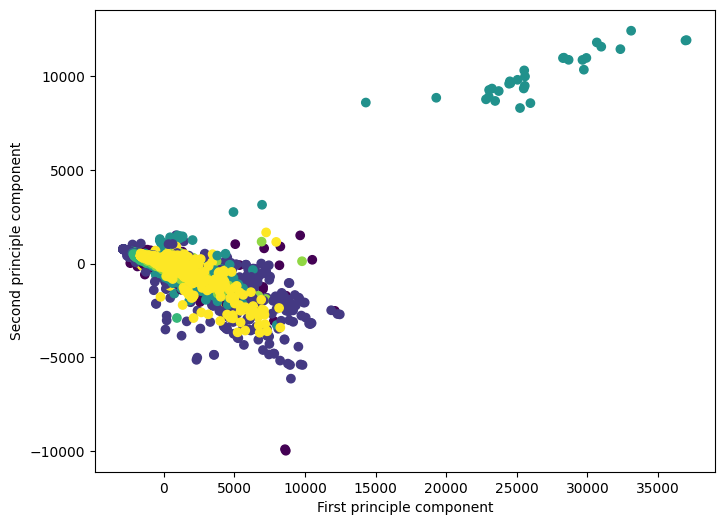

In [77]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=emg_labels_NC_df['Subject'])
plt.xlabel('First principle component')
plt.ylabel('Second principle component')

Could drop channel column, or combine subject and channel into 1 label. Dropping channel column is easiest but presumably loses some info (eg if channel is place over same muscle that could provide a better matching criterion, but this may be counteracted if the two blocks had sensors placed in different places

In [54]:
emg_labels_df.head()

,Subject,Condition
0,METACPHS_S106,0
1,METACPHS_S106,0
2,METACPHS_S106,0
3,METACPHS_S106,0
4,METACPHS_S106,0


In [ ]:
# Also drop condition for now
emg_labels_NC_df = emg_labels_df.drop(['Channel', 'Condition'], axis=1)
print(emg_labels_NC_df.shape)
emg_labels_NC_df.head()

In [69]:
emg_labels_NC_df["Subject"] = emg_labels_NC_df["Subject"].map(key_to_num)
emg_labels_NC_df.head()

,Subject,Condition
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [71]:
print(emg_labels_NC_df.shape)
print(emg_PCA_df.shape)
assert(emg_labels_NC_df.shape[0]==emg_PCA_df.shape[0])

(7232, 1)
(7232, 2)


In [62]:
emgPCA_res_df = pd.DataFrame(columns=my_metrics_cols)
emgPCA_res_df.head()

,Algorithm,One Off Acc,CV Acc,K Folds


In [59]:
emg_PCA_df = pd.DataFrame(x_pca)

In [72]:
try:
    X_train, y_train, X_test, y_test, X_val, y_val = train_test_val_split(emg_PCA_df, emg_labels_NC_df)
except ValueError:
    # You probably turned off validation so just remove the val sets
    print("Excepted value error")
    X_train, y_train, X_test, y_test = train_test_val_split(emg_PCA_df, emg_labels_NC_df)
y_train = np.ravel(y_train)

print(X_train.shape)
X_train.head()

(5062, 2)


,0,1
3682,-1319.251174,308.184261
5072,-1413.467823,403.857583
1420,-123.295793,53.505941
278,5205.725691,-1088.213721
1452,-1861.596304,459.965769


In [73]:
for model in my_models:
    emgPCA_res_df = train_model(model, X_train, y_train, cv, emgPCA_res_df)

C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid t

In [75]:
emgPCA_res_df.head(100)

,Algorithm,One Off Acc,CV Acc,K Folds
0,LogisticRegression(),23.133,23.173,10
0,KNeighborsClassifier(),52.963,32.576,10
0,GaussianNB(),26.669,26.452,10
0,LinearSVC(),20.190,14.559,10
0,SGDClassifier(),16.772,14.718,10
0,DecisionTreeClassifier(),100.000,30.324,10
0,GradientBoostingClassifier(),51.877,36.547,10


## 3) Cluster Decoder Matrix Norms